# Classification using the k‑Nearest Neighbors (kNN) Algorithm

|                  |                                                                                                                                         |
|:-----------------|:----------------------------------------------------------------------------------------------------------------------------------------|
| **Course Codes** | BBT 4206 and BFS 4102                                                                                                                   |
| **Course Names** | BBT 4206: Business Intelligence II (Week 4-6 of 13) and BFS 4102: Advanced Business Data Analytics (Week 4-6 of 13)                     |
| **Semester**     | April to July 2025                                                                                                                      |
| **Lecturer**     | Allan Omondi                                                                                                                            |
| **Contact**      | aomondi@strathmore.edu                                                                                                                  |
| **Note**         | The lecture contains both theory and practice. This notebook forms part of the practice. This is intended for educational purpose only. |

**Business context**: A global retail company has set a strategic objective *to increase customer satisfaction to 8/10 by Q3 of the current financial year.* The lagging KPI in the customer perspective is the customer satisfaction rating whereas its leading KPI is the number of late deliveries. The business would like to predict whether an order will arrive late so that supply chain management and logistics teams can intervene early and avoid dissatisfied customers.

**Dataset**: The **"DataCo Smart Supply Chain"** dataset by **Constante et al. (2019)** contains 180,519 orders. A description of each feature and the target is presented via [this link](https://github.com/course-files/RegressionAndClassification/blob/main/data/DataCoSupplyChainDataset_description.csv). The following table presents the chosen features and the target.

| **Type**    | **Name**                        | **Description**                                                                                 |
|:------------|---------------------------------|:------------------------------------------------------------------------------------------------|
| **Feature** | `Days for shipping (real)`      | Actual shipping days of the purchased product                                                   |
| **Feature** | `Days for shipment (scheduled)` | Days of scheduled delivery of the purchased product                                             |
| **Feature** | `Order Item Quantity`           | Number of products per order                                                                    |
| **Feature** | `Sales`                         | Value in sales                                                                                  |
| **Feature** | `Order Profit Per Order`        | Profit made through the order                                                                   |
| **Feature** | `Shipping Mode`                 | The following shipping modes are presented: Standard Class, First Class, Second Class, Same Day |
| **Target**  | `Late_delivery_risk`            | A categorical variable that indicates if sending is late (1) or it is not late (0)              |

## Step 1: Import the necessary libraries

**Purpose**: This chunk imports all the necessary libraries for data analysis, machine learning, and visualization related to the k-Nearest Neighbors classifier.

1. **Data Manipulation Libraries**
    - `pandas as pd`: For loading the dataset, creating and managing DataFrames, data manipulation and analysis using DataFrames
    - `numpy as np`: For numerical operations and array manipulations

2. **Machine Learning (scikit-learn) Components**
    - `train_test_split`: Splits data into training and testing sets
    - `GridSearchCV`: For hyperparameter tuning using cross-validation
    - `StandardScaler`: For feature scaling
    - `KNeighborsClassifier`: For implementing the kNN algorithm
    - `classification_report, confusion_matrix`: For model evaluation metrics

3. **Statistical Analysis (SciPy)**
    - `kurtosis`: Measures the "tailedness" of data distribution
    - `skew`: Measures the asymmetry of data distribution

4. **Visualization Libraries**
    - `matplotlib.pyplot as plt`: For basic plotting functionality
    - `seaborn as sns`: For enhanced statistical visualizations

5. **Warnings Management**
    - `warnings`: Controls warning messages
    - `warnings.filterwarnings('ignore')`: Suppresses warning messages for cleaner output
    - Used to suppress warnings that may arise during the execution of the code. Even though it is not necessary for the code to run, it helps in keeping the output clean and focused on the results.

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import kurtosis
from scipy.stats import skew
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Step 2: Load the data

**Purpose:** This chunk handles the loading of the supply chain dataset with specific column selection.

1. **URL Configuration**
    - A commented-out local path option is provided (`./data/DataCoSupplyChainDataset.csv`)
    - Currently using a direct GitHub raw content URL for data access
    - This ensures data accessibility without requiring local file downloads

2. **Data Loading Parameters**
    - Uses `pandas.read_csv()` with specific parameters:
        - `usecols`: Loads only the columns specified in `use_cols` for memory efficiency
        - `encoding='latin-1'`: Handles special characters in the dataset. Other encodings like 'utf-8' may not work if the dataset contains characters outside the standard ASCII range. 'latin-1' is a common encoding that supports Western European languages and is often used when dealing with CSV files that contain special characters such as accents or currency symbols; ñ and €
        - `nrows=200000`: Limits the number of rows loaded to 200,000. This can be reduced or increased based on the available memory and the size of the dataset.
    - Data is stored in the `supply_chain_data` DataFrame for further analysis
    - This selective loading approach helps manage memory usage and focuses the analysis on the relevant features for the delivery risk prediction task.


In [76]:
# url = './data/DataCoSupplyChainDataset.csv'
url = 'https://raw.githubusercontent.com/course-files/RegressionAndClassification/main/data/DataCoSupplyChainDataset.csv'
use_cols = ['Days for shipping (real)', 'Days for shipment (scheduled)',
            'Order Item Quantity', 'Sales', 'Order Profit Per Order',
            'Shipping Mode', 'Late_delivery_risk']
supply_chain_data = pd.read_csv(url, usecols=use_cols, encoding='latin-1', nrows=200000)

## Step 3: Initial Exploratory Data Analysis (EDA)

In [77]:
print("\n*1* The number of observations and variables")
display(supply_chain_data.shape)

print("\n*2* The data types:")
display(supply_chain_data.info())

print("\n*3* The summary of the numeric columns:")
display(supply_chain_data.describe())

print("\n*4* The whole dataset:")
display(supply_chain_data)

print("\n*5* The first 5 rows in the dataset:")
display(supply_chain_data.head())

print("\n*6* Percentage distribution for each category")
print("\nNumber of observations per class:")
print("Frequency counts:\n", supply_chain_data['Late_delivery_risk'].value_counts())
print("\nPercentages:\n", supply_chain_data['Late_delivery_risk'].value_counts(normalize=True) * 100, "%")


*1* The number of observations and variables


(180519, 7)


*2* The data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 7 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Days for shipping (real)       180519 non-null  int64  
 1   Days for shipment (scheduled)  180519 non-null  int64  
 2   Late_delivery_risk             180519 non-null  int64  
 3   Order Item Quantity            180519 non-null  int64  
 4   Sales                          180519 non-null  float64
 5   Order Profit Per Order         180519 non-null  float64
 6   Shipping Mode                  180519 non-null  object 
dtypes: float64(2), int64(4), object(1)
memory usage: 9.6+ MB


None


*3* The summary of the numeric columns:


,Days for shipping (real),Days for shipment (scheduled),Late_delivery_risk,Order Item Quantity,Sales,Order Profit Per Order
count,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000
mean,3.497654,2.931847,0.548291,2.127638,203.772096,21.974989
std,1.623722,1.374449,0.497664,1.453451,132.273077,104.433526
min,0.000000,0.000000,0.000000,1.000000,9.990000,-4274.979980
25%,2.000000,2.000000,0.000000,1.000000,119.980003,7.000000
50%,3.000000,4.000000,1.000000,1.000000,199.919998,31.520000
75%,5.000000,4.000000,1.000000,3.000000,299.950012,64.800003
max,6.000000,4.000000,1.000000,5.000000,1999.989990,911.799988



*4* The whole dataset:


,Days for shipping (real),Days for shipment (scheduled),Late_delivery_risk,Order Item Quantity,Sales,Order Profit Per Order,Shipping Mode
0,3,4,0,1,327.750000,91.250000,Standard Class
1,5,4,1,1,327.750000,-249.089996,Standard Class
2,4,4,0,1,327.750000,-247.779999,Standard Class
3,3,4,0,1,327.750000,22.860001,Standard Class
4,2,4,0,1,327.750000,134.210007,Standard Class
...,...,...,...,...,...,...,...
180514,4,4,0,1,399.980011,40.000000,Standard Class
180515,3,2,1,1,399.980011,-613.770019,Second Class
180516,5,4,1,1,399.980011,141.110001,Standard Class
180517,3,4,0,1,399.980011,186.229996,Standard Class



*5* The first 5 rows in the dataset:


,Days for shipping (real),Days for shipment (scheduled),Late_delivery_risk,Order Item Quantity,Sales,Order Profit Per Order,Shipping Mode
0,3,4,0,1,327.75,91.250000,Standard Class
1,5,4,1,1,327.75,-249.089996,Standard Class
2,4,4,0,1,327.75,-247.779999,Standard Class
3,3,4,0,1,327.75,22.860001,Standard Class
4,2,4,0,1,327.75,134.210007,Standard Class



*6* Percentage distribution for each category

Number of observations per class:
Frequency counts:
 Late_delivery_risk
1    98977
0    81542
Name: count, dtype: int64

Percentages:
 Late_delivery_risk
1    54.829132
0    45.170868
Name: proportion, dtype: float64 %


### Measures of Distribution

#### Variance of numeric columns

**Selection of numeric columns**
- The code selects columns with numeric data types (`int64` and `float64`) that can be subjected to mathematica or statistical functions.
- This is done using `select_dtypes()` method of the DataFrame, which filters columns based on their data types.

In [78]:
numeric_cols = supply_chain_data.select_dtypes(include=['int64', 'float64']).columns
print("\nVariance of the numeric columns:")
print(supply_chain_data[numeric_cols].var())


Variance of the numeric columns:
Days for shipping (real)             2.636473
Days for shipment (scheduled)        1.889111
Late_delivery_risk                   0.247669
Order Item Quantity                  2.112521
Sales                            17496.167031
Order Profit Per Order           10906.361300
dtype: float64


#### Standard deviation of numeric columns

In [79]:
print("\nStandard deviation of the numeric columns:")
print(supply_chain_data[numeric_cols].std())


Standard deviation of the numeric columns:
Days for shipping (real)           1.623722
Days for shipment (scheduled)      1.374449
Late_delivery_risk                 0.497664
Order Item Quantity                1.453451
Sales                            132.273077
Order Profit Per Order           104.433526
dtype: float64


#### Kurtosis of numeric columns

In [80]:
print("\nFisher Kurtosis of numeric columns:")
print("\nInterpretation:")
print("→ Positive kurtosis indicates heavier tails (more outliers) than what is expected in a normal distribution - leptokurtic")
print("→ Negative kurtosis indicates lighter tails (less outliers) than what is expected in a normal distribution - platykurtic")
print("→ A normal distribution has kurtosis of 0 - mesokurtic")
print("\nKurtosis values:")
print(supply_chain_data[numeric_cols].apply(lambda x: kurtosis(x, fisher=True)))


Fisher Kurtosis of numeric columns:

Interpretation:
→ Positive kurtosis indicates heavier tails (more outliers) than what is expected in a normal distribution - leptokurtic
→ Negative kurtosis indicates lighter tails (less outliers) than what is expected in a normal distribution - platykurtic
→ A normal distribution has kurtosis of 0 - mesokurtic

Kurtosis values:
Days for shipping (real)         -1.007919
Days for shipment (scheduled)    -1.022954
Late_delivery_risk               -1.962336
Order Item Quantity              -0.753714
Sales                            23.935865
Order Profit Per Order           71.375248
dtype: float64


#### Skewness of numeric columns

In [81]:
print("\nSkewness of numeric columns:")
print("\nInterpretation:")
print("→ Positive skewness indicates a long right tail (right-skewed distribution)")
print("→ Negative skewness indicates a long left tail (left-skewed distribution)")
print("→ Skewness close to 0 indicates a symmetric distribution")
print("\nSkewness values:")
print(supply_chain_data[numeric_cols].apply(lambda x: skew(x)))


Skewness of numeric columns:

Interpretation:
→ Positive skewness indicates a long right tail (right-skewed distribution)
→ Negative skewness indicates a long left tail (left-skewed distribution)
→ Skewness close to 0 indicates a symmetric distribution

Skewness values:
Days for shipping (real)         0.084771
Days for shipment (scheduled)   -0.731992
Late_delivery_risk              -0.194073
Order Item Quantity              0.880245
Sales                            2.884225
Order Profit Per Order          -4.741795
dtype: float64


### Measures of Relationship

#### Covariance matrix of numeric features

In [82]:
print("\nCovariance matrix of numeric features:")
print("\nInterpretation:")
print("→ Positive values indicate that variables move in the same direction")
print("→ Negative values indicate that variables move in opposite directions")
print("→ Values close to 0 indicate little to no linear relationship")
print("\nCovariance values:")
display(supply_chain_data[numeric_cols].cov())


Covariance matrix of numeric features:

Interpretation:
→ Positive values indicate that variables move in the same direction
→ Negative values indicate that variables move in opposite directions
→ Values close to 0 indicate little to no linear relationship

Covariance values:


,Days for shipping (real),Days for shipment (scheduled),Late_delivery_risk,Order Item Quantity,Sales,Order Profit Per Order
Days for shipping (real),2.636473,1.151301,0.324370,-0.001914,0.421390,-0.865031
Days for shipment (scheduled),1.151301,1.889111,-0.252642,-0.005842,1.150190,-0.026560
Late_delivery_risk,0.324370,-0.252642,0.247669,-0.000101,-0.234633,-0.193702
Order Item Quantity,-0.001914,-0.005842,-0.000101,2.112521,20.463748,2.382514
Sales,0.421390,1.150190,-0.234633,20.463748,17496.167031,1820.866786
Order Profit Per Order,-0.865031,-0.026560,-0.193702,2.382514,1820.866786,10906.361300


#### Correlation matrix of numeric features

In [83]:
print("\nSpearman's rank correlation matrix of numeric features:")
spearman_corr = supply_chain_data[numeric_cols].corr(method='spearman')
print("\nInterpretation:")
print("→ Values range from -1 to +1")
print("→ +1 indicates perfect positive correlation")
print("→ -1 indicates perfect negative correlation")
print("→ 0 indicates no correlation")
print("\nCorrelation values:")
display(spearman_corr)


Spearman's rank correlation matrix of numeric features:

Interpretation:
→ Values range from -1 to +1
→ +1 indicates perfect positive correlation
→ -1 indicates perfect negative correlation
→ 0 indicates no correlation

Correlation values:


,Days for shipping (real),Days for shipment (scheduled),Late_delivery_risk,Order Item Quantity,Sales,Order Profit Per Order
Days for shipping (real),1.000000,0.500262,0.367384,-0.000385,-0.000156,-0.002671
Days for shipment (scheduled),0.500262,1.000000,-0.388240,-0.002252,0.002958,0.000297
Late_delivery_risk,0.367384,-0.388240,1.000000,-0.000555,-0.002832,-0.002947
Order Item Quantity,-0.000385,-0.002252,-0.000555,1.000000,0.085291,0.061486
Sales,-0.000156,0.002958,-0.002832,0.085291,1.000000,0.436303
Order Profit Per Order,-0.002671,0.000297,-0.002947,0.061486,0.436303,1.000000


### Basic visualization of the data

- `n_cols = 3` Sets the number of plots per row to 3
- `n_rows = (len(numeric_cols) // n_cols) + (1 if len(numeric_cols) % n_cols else 0)` Calculates the number of rows needed based on the number of numeric columns and the number of columns per row.
- `plt.figure(figsize=(12, 5 * n_rows))` Sets the figure size to be wider and taller based on the number of rows.
- `for i, col in enumerate(numeric_cols, 1):` Iterates over each numeric column (`numeric_cols`), starting the index at 1. `enumerate(numeric_cols, 1)` returns pairs of (index, value) for each item in the list. The 1 means that the index will start from 1, e.g., (1, 'Days for shipping (real)'), (2, 'Days for shipment (scheduled)'), etc.
- `plt.subplot(n_rows, n_cols, i)` Creates a subplot in a grid layout with `n_rows` rows and `n_cols` columns, placing the current plot in the `i`-th position.
- `sns.histplot(data=supply_chain_data, x=col)` Plots a histogram for the current numeric column using Seaborn's `histplot` function.
- `sns.boxplot(data=supply_chain_data, y=col)` Plots a box plot for the current numeric column using Seaborn's `boxplot` function.
- `sns.despine(right=True, top=True)` Removes the right and top spines (borders) of the plot for a cleaner look.
- `plt.title(f'Distribution of {col}')` Sets the title of the current subplot to indicate which column's distribution is being shown.
- `plt.grid(axis='y', alpha=0.2)` Adds a grid to the y-axis with a transparency level of 0.2 for better visibility.
- `plt.grid(axis='x', visible=False)` Hides the grid for the x-axis to reduce clutter and increase the data-to-ink ratio.
- `plt.tight_layout()` Adjusts the spacing between subplots to prevent overlap and ensure a clean layout.
- `plt.show()` Displays the entire figure with all subplots.

#### Histograms

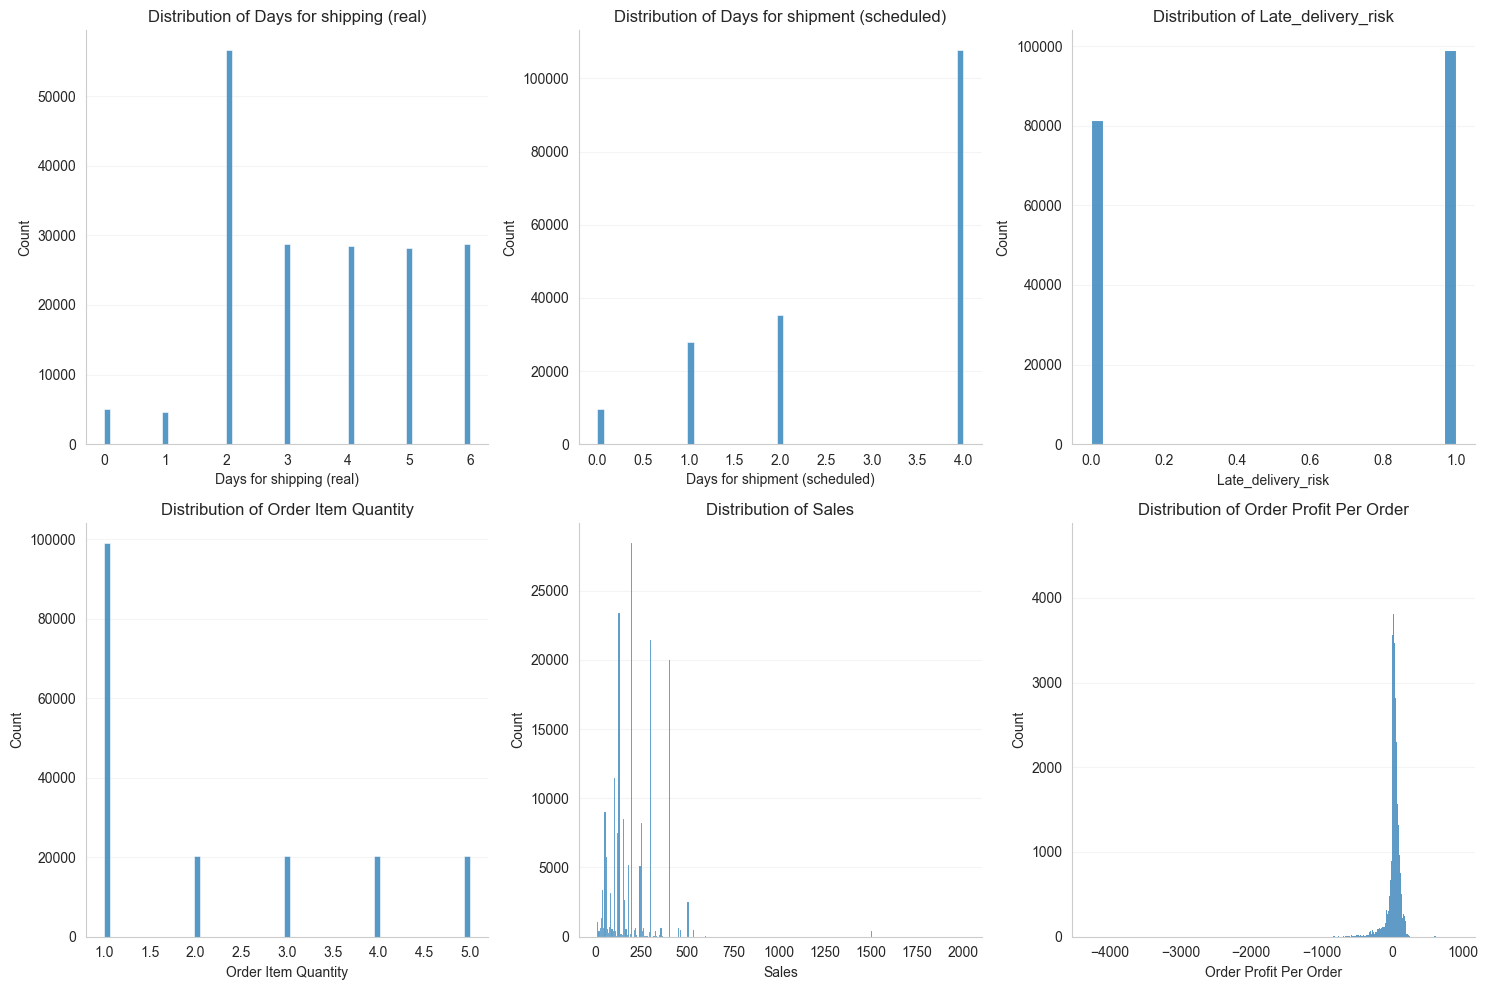

In [84]:
n_cols = 3
n_rows = (len(numeric_cols) // n_cols) + (1 if len(numeric_cols) % n_cols else 0)

plt.figure(figsize=(15, 5 * n_rows))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(data=supply_chain_data, x=col)
    sns.despine(right=True, top=True)
    plt.title(f'Distribution of {col}')
    plt.grid(axis='y', alpha=0.2)
    plt.grid(axis='x', visible=False)
plt.tight_layout()  # Adjust spacing
plt.show()

#### Box plots

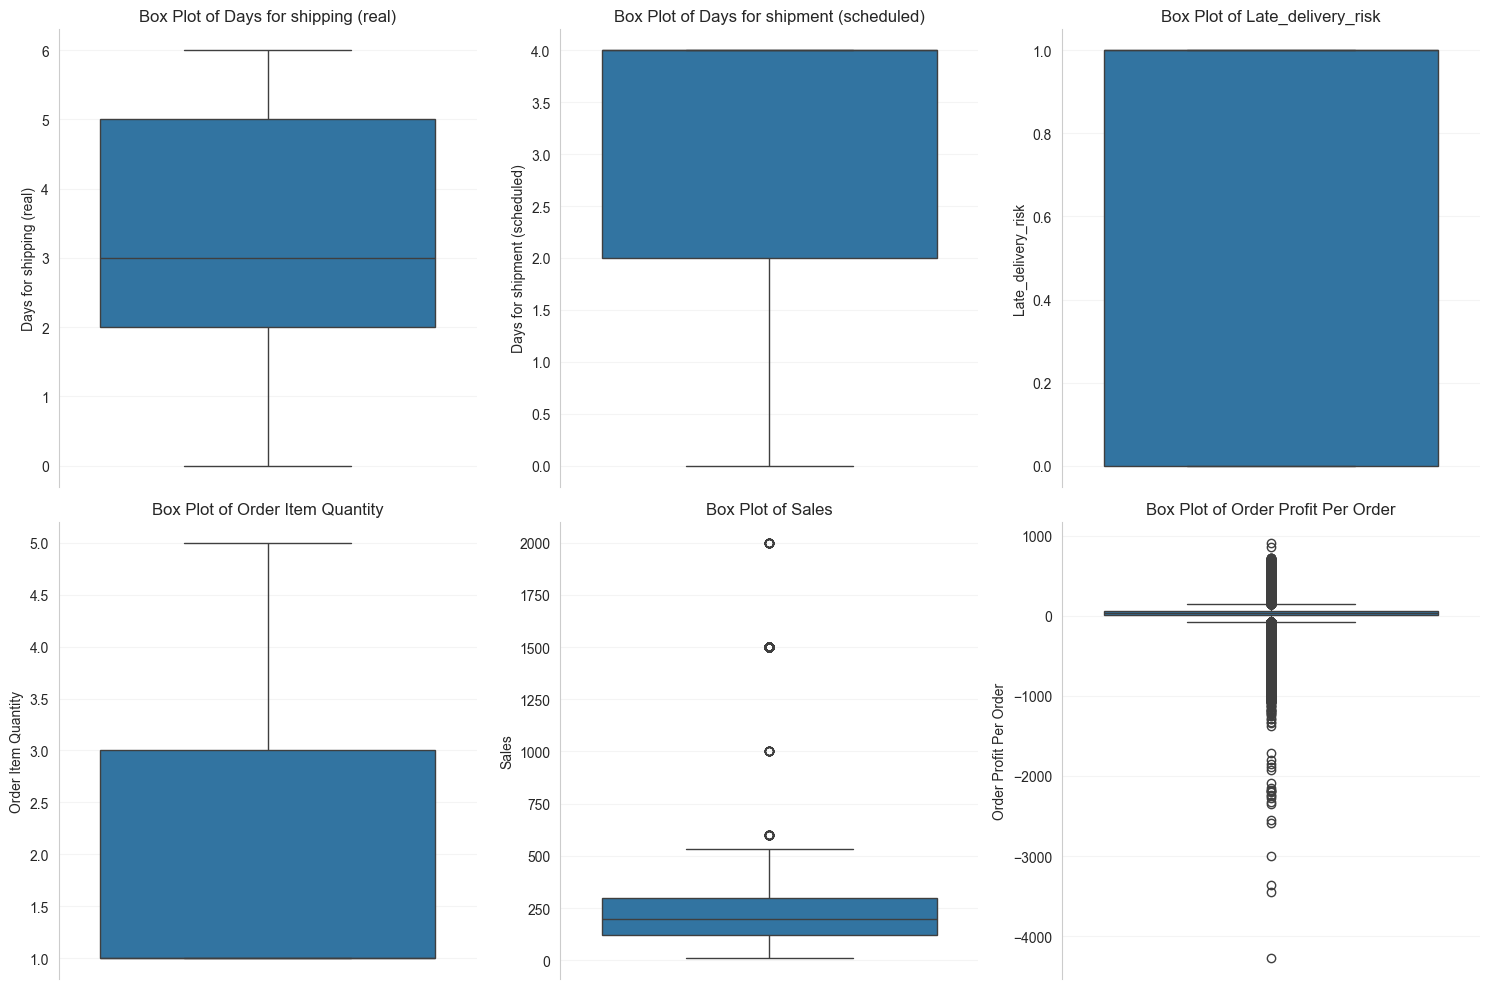

In [85]:
n_cols = 3
n_rows = (len(numeric_cols) // n_cols) + (1 if len(numeric_cols) % n_cols else 0)

plt.figure(figsize=(15, 5 * n_rows))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=supply_chain_data, y=col)
    sns.despine(right=True, top=True, bottom=True)
    plt.title(f'Box Plot of {col}')
    plt.grid(axis='y', alpha=0.2)
    plt.grid(axis='x', visible=False)
plt.tight_layout()
plt.show()

#### Missing data plot

- This visualization helps to quickly identify which columns have missing values and the extent of the missing data. The heatmap will show yellow for missing values and purple for non-missing values, making it easy to spot patterns of missingness. This is useful for understanding the completeness of the dataset and deciding how to handle missing values in subsequent analysis.
- The code uses `sns.heatmap()` to visualize missing data in the DataFrame.
- The code also uses the `isnull()` method to create a boolean DataFrame indicating where values are missing (True) or present (False).
- `yticklabels=False` hides the y-axis labels to reduce clutter.
- `cbar=False` removes the color bar, which is not necessary for this plot.
- `cmap='viridis'` sets the color map to 'viridis' which is a perceptually uniform color map suitable for visualizing missing data.
- `plt.title('Missing Data')` sets the title of the plot to 'Missing Data'
- `plt.show()` displays the plot.

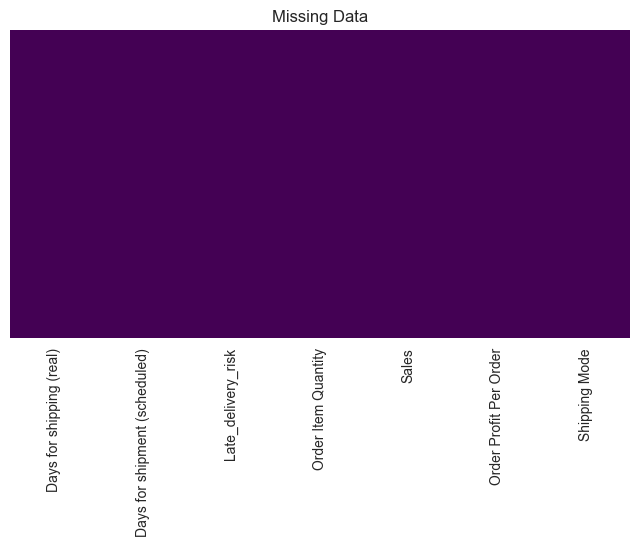

In [86]:
plt.figure(figsize=(8, 4))
sns.heatmap(supply_chain_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Missing Data')
plt.show()

#### Correlation heatmap

- This visualization helps to quickly identify relationships between numeric features. The heatmap will show the strength and direction of correlations, with colors indicating positive (red) or negative (blue) correlations. This is useful for understanding how features relate to each other and can inform feature selection or feature engineering in subsequent analysis.
- The code uses `sns.heatmap()` to visualize the Spearman correlation matrix of the numeric features in the DataFrame.
- `annot=True` adds the correlation values as annotations in the heatmap.
- `cmap='coolwarm'` sets the color map to 'coolwarm' which provides a gradient from blue (negative correlation) to red (positive correlation).
- `center=0` centers the color map at 0, which is useful for visualizing both positive and negative correlations.

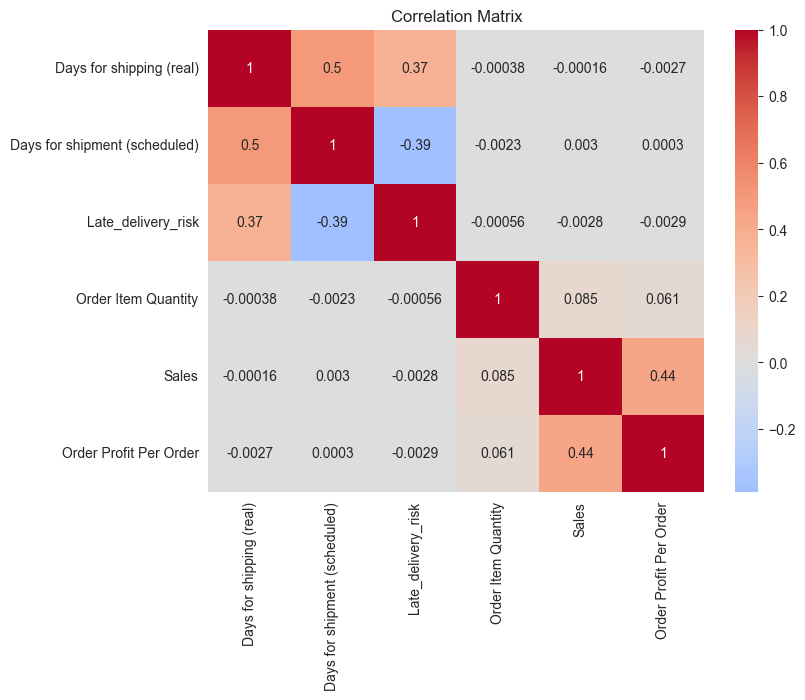

In [87]:
plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

#### Scatter plot matrix

- This visualization helps to quickly identify relationships between pairs of numeric features. The scatter plot matrix will show scatter plots for each pair of numeric features, allowing for visual inspection of relationships, trends, and potential outliers. This is useful for understanding how features interact with each other and can inform feature selection or feature engineering in subsequent analysis.
- The code uses `sns.pairplot()` to create a scatter plot matrix of the numeric features in the DataFrame

<Figure size 1000x1000 with 0 Axes>

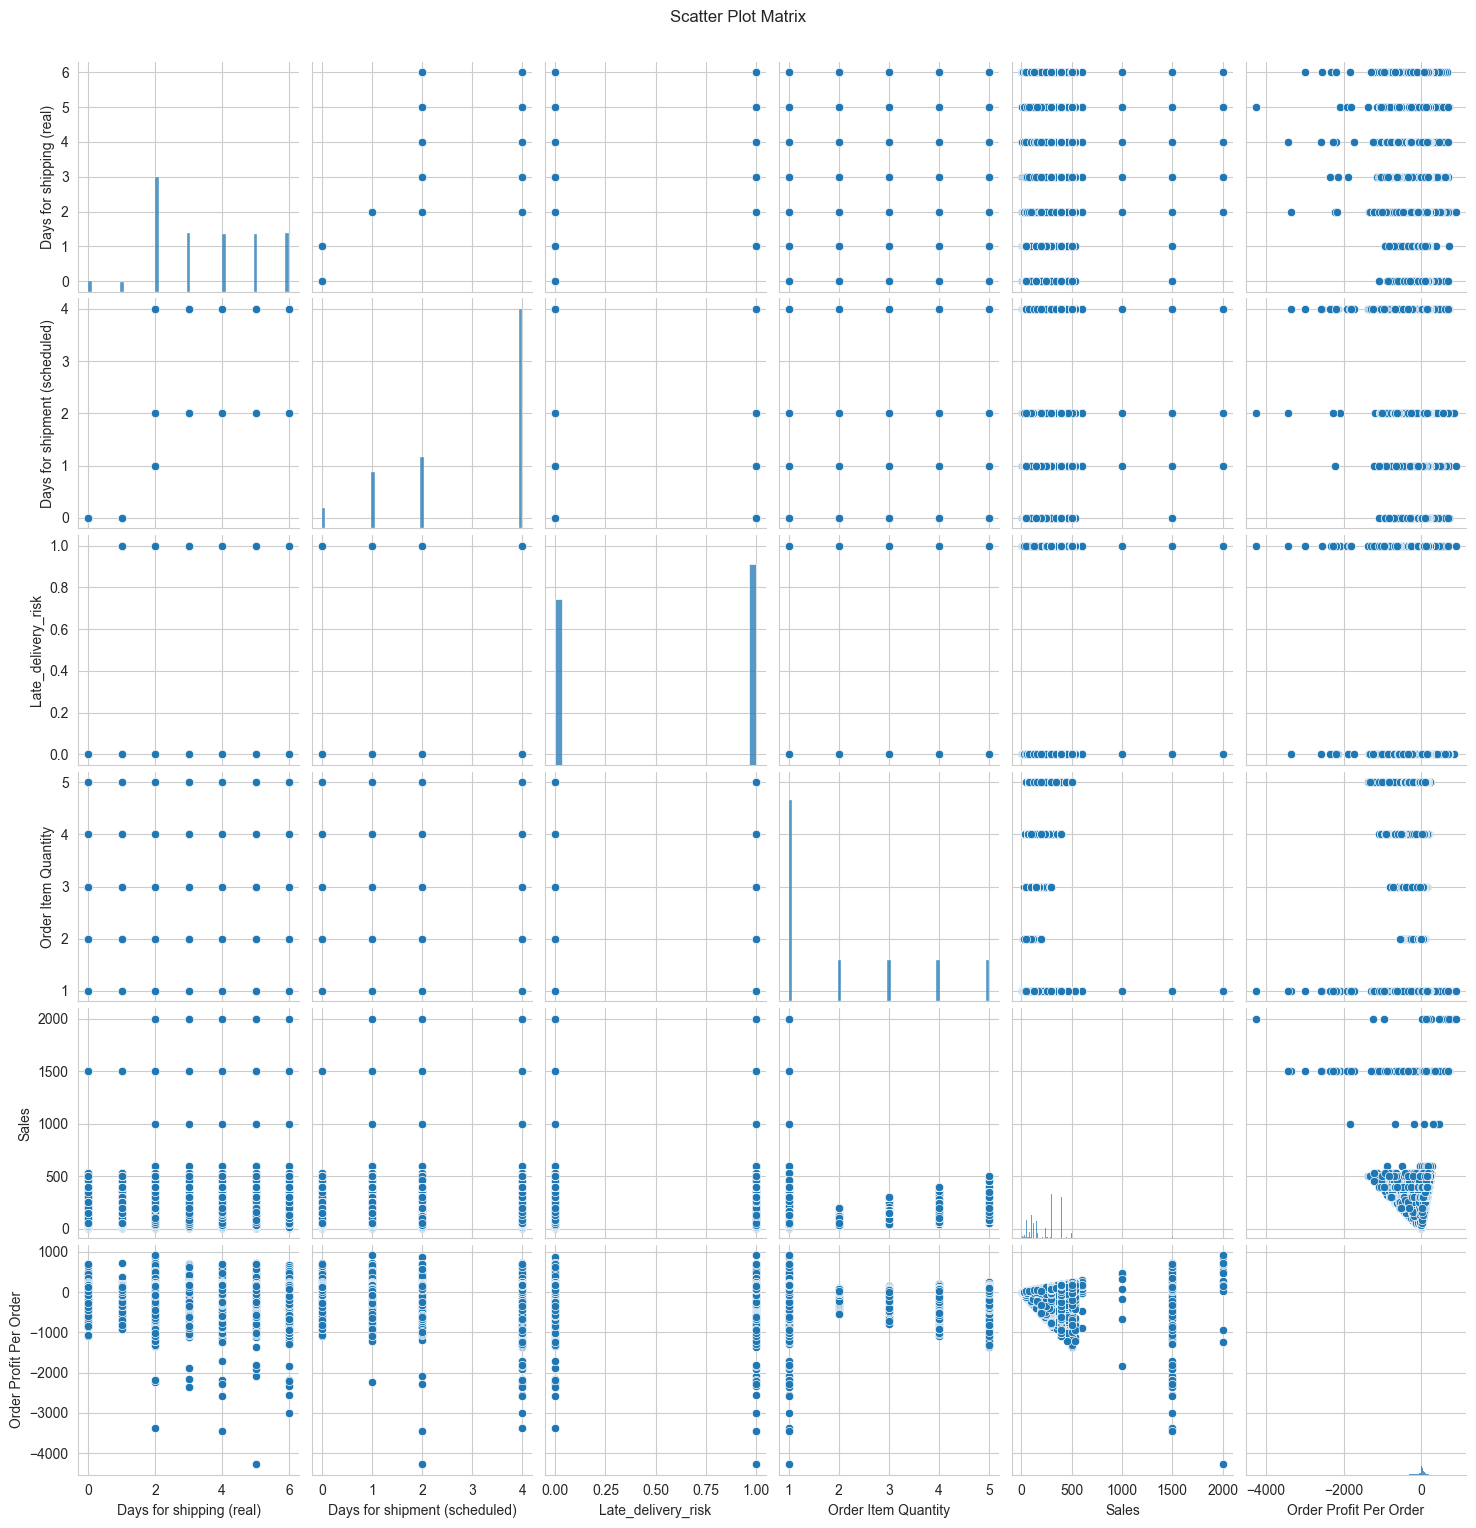

In [88]:
plt.figure(figsize=(10, 10))
sns.pairplot(supply_chain_data[numeric_cols])
plt.suptitle('Scatter Plot Matrix', y=1.02)
plt.show()

## Step 4: Data preparation

### Remove rows with missing target values (if any)

- This step is crucial because the target variable (`Late_delivery_risk`) is essential for training the kNN model. If there are missing values in the target variable, the model cannot learn from those observations, leading to potential errors during training and evaluation.
- The code uses `dropna()` to remove rows where the target variable (`Late_delivery_risk`) is missing. This ensures that only complete cases are used for model training and evaluation.
- `pd.get_dummies()` is used to convert the categorical variable `Shipping Mode` into dummy variables (one-hot encoding). This is necessary because Machine Learning algorithms typically require numerical input, and one-hot encoding transforms categorical variables into a format that can be provided to the ML algorithm.
- `drop_first=True` is used to avoid the dummy variable trap, which occurs when one category can be perfectly predicted from the others. By dropping the first category, we reduce multicollinearity in the dataset.

In [89]:
supply_chain_data = supply_chain_data.dropna(subset=['Late_delivery_risk'])
supply_chain_data = pd.get_dummies(supply_chain_data, columns=['Shipping Mode'], drop_first=True)

### Create X and y datasets for the features and target variable respectively

- This step separates the features (independent variables) from the target variable (dependent variable) in the dataset. The features are stored in `X`, and the target variable is stored in `y`.
- `X` contains all the columns except the target variable `Late_delivery_risk`, which is dropped using `drop()`.
- `y` contains only the target variable `Late_delivery_risk`.

In [90]:
X = supply_chain_data.drop('Late_delivery_risk', axis=1)
y = supply_chain_data['Late_delivery_risk']

print("\nThe number of observations and variables in the features dataset")
print(X.shape)

print("\nThe number of observations and variables in the target dataset")
print(y.shape)


The number of observations and variables in the features dataset
(180519, 8)

The number of observations and variables in the target dataset
(180519,)


### Train‑test split and scaling

- This step splits the dataset into training and testing sets to evaluate the model's performance on unseen data. The `train_test_split()` function is used to randomly split the data, ensuring that the target variable's distribution is preserved in both sets using `stratify=y`.
- `test_size=0.3` indicates that 30% of the data will be used for testing, while 70% will be used for training.
- `random_state=53` ensures reproducibility of the split, meaning that every time you run the code, you will get the same split of data.
- `StandardScaler()` is used to standardize the features by setting mean = 0 and variance = 1. This is important for kNN, as it is sensitive to the scale of the features. Standardization ensures that all features contribute equally to the distance calculations.
- `fit_transform()` is applied to the training data to compute the mean and standard deviation, and then transform the data accordingly.
- `transform()` is applied to the test data using the same scaler fitted on the training data. This ensures that the test data is scaled in the same way as the training data, preventing data leakage.

In [95]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=53, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Step 5: Create a baseline kNN model (k = 5)

- This step creates a baseline kNN model using the `KNeighborsClassifier` from scikit-learn with `n_neighbors=5`. This means that the model will consider the 5 nearest neighbors to make predictions.
- `fit()` is called on the training data to train the model, and `predict()` is used to make predictions on the test data.
- `confusion_matrix()` is used to compute the confusion matrix, which shows the number of true positives, true negatives, false positives, and false negatives.
- `classification_report()` is used to generate a report that includes precision, recall, F1-score, and support for each class in the target variable. This provides a detailed evaluation of the model's performance.
- This step is essential for establishing a baseline performance of the kNN model, which can be improved through hyperparameter tuning in subsequent steps.

In [96]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
y_pred = knn_model.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[23124  1339]
 [   47 29646]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     24463
           1       0.96      1.00      0.98     29693

    accuracy                           0.97     54156
   macro avg       0.98      0.97      0.97     54156
weighted avg       0.98      0.97      0.97     54156



## Step 6: Perform hyperparameter tuning

- This step performs hyperparameter tuning using `GridSearchCV` to find the optimal number of neighbors (`n_neighbors`) and the weighting method (`weights`) for the kNN model.
- `param_grid` defines the hyperparameters to be tuned:
    - `n_neighbors`: A range of odd numbers from 3 to 15 (inclusive) to avoid ties in classification.
    - `weights`: Two options: 'uniform' (all neighbors contribute equally) and 'distance' (closer neighbors contribute more).
- `GridSearchCV` performs an exhaustive search over the specified hyperparameters using 5-fold cross-validation (`cv=5`). This means that the training data is split into 5 subsets, and the model is trained and evaluated 5 times, each time using a different subset as the validation set.
- `n_jobs=-1` allows the search to use all available CPU cores for parallel processing, speeding up the tuning process.
- `fit()` is called on the training data to perform the grid search, and the best hyperparameters are printed.
- `best_score_` gives the best cross-validated accuracy score, and `best_params_` provides the optimal hyperparameters found during the search.
- Finally, the optimal kNN model is evaluated on the test data using `score()`, which returns the accuracy of the model on the test set.

In [102]:
param_grid = {'n_neighbors': range(3, 17, 2),
              'weights': ['uniform', 'distance']}
grid = GridSearchCV(KNeighborsClassifier(), param_grid,
                    cv=5, n_jobs=-1)
grid.fit(X_train_scaled, y_train)
print('Best params:', grid.best_params_)
print('CV accuracy:', grid.best_score_.round(3))
optimal_knn_model = grid.best_estimator_
print('Test accuracy:', f"{optimal_knn_model.score(X_test_scaled, y_test):.3f}")

Best params: {'n_neighbors': 11, 'weights': 'uniform'}
CV accuracy: 0.975
Test accuracy: 0.975


## Step 7: Make predictions on new data and save the results for reporting in Power BI

- This step demonstrates how to make predictions on new data using the optimal kNN model obtained from hyperparameter tuning.
- The new data is loaded from a CSV file (`DataCoSupplyChainDataset_new_data.csv`), which should have the same structure as the training data.
- The new data is preprocessed in the same way as the training data:
    - Categorical variables are converted to dummy variables using `pd.get_dummies()`.
    - Any missing columns that were present in the training data but not in the new data are added with a value of 0.
    - The columns are reordered to match the training data.
- The new data is scaled using the same `StandardScaler` fitted on the training data. Without this step, the model would not be able to make accurate predictions because the features would not be on the same scale as those used during training. kNN is sensitive to the scale of the features because it uses distance metrics (like Euclidean distance) to determine the nearest neighbors.
- `predict()` is called on the scaled new data to get predictions for the `Late_delivery_risk` target variable.
- The predictions are then added to the original new data DataFrame as a new column (`Predicted_Late_Delivery`).
- The results are saved to a new CSV file (`DataCoSupplyChainDataset_predicted.csv`) for reporting in Power BI.

In [113]:
# 1. Load your new data
new_data = pd.read_csv('./data/DataCoSupplyChainDataset_new_data.csv')

# 2. Prepare the data (same preprocessing as training data)
# Create fake variables for Shipping Mode
new_data_processed = pd.get_dummies(new_data, columns=['Shipping Mode'], drop_first=True)

# 3. Make sure you have all the necessary columns (match training data)
missing_cols = set(X.columns) - set(new_data_processed.columns)
for col in missing_cols:
    new_data_processed[col] = 0

# Ensure columns are in the same order as training data
new_data_processed = new_data_processed[X.columns]

# 4. Scale the data using the same scaler
new_data_scaled = scaler.transform(new_data_processed)

# 5. Make predictions
predictions = optimal_knn_model.predict(new_data_scaled)

# 6. Add predictions and probabilities of the predictions to the original dataframe and save it
new_data['Predicted_Late_Delivery'] = predictions
probabilities = optimal_knn_model.predict_proba(new_data_scaled)
new_data['Late_Delivery_Probability_Class_0'] = probabilities[:, 0]  # Probability of on-time delivery
new_data['Late_Delivery_Probability_Class_1'] = probabilities[:, 1]  # Probability of late delivery

print("\nThe new data with predictions:")
display(new_data)
new_data.to_csv('./data/DataCoSupplyChainDataset_predicted_data.csv', index=False)

,Days for shipping (real),Days for shipment (scheduled),Late_delivery_risk,Order Item Quantity,Sales,Order Profit Per Order,Shipping Mode,Predicted_Late_Delivery,Late_Delivery_Probability_Class_0,Late_Delivery_Probability_Class_1
0,3,4,0,5,250.000000,64.169998,Standard Class,0,1.000000,0.000000
1,2,4,0,1,59.990002,4.330000,Standard Class,0,1.000000,0.000000
2,3,4,0,2,119.980003,44.270000,Standard Class,0,1.000000,0.000000
3,2,1,1,1,129.990005,35.150002,First Class,1,0.090909,0.909091
4,5,4,1,1,129.990005,15.920000,Standard Class,1,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...
144,5,4,1,1,39.990002,-7.900000,Standard Class,1,0.000000,1.000000
145,5,4,1,1,50.000000,1.520000,Standard Class,1,0.000000,1.000000
146,5,4,1,1,299.980011,124.940002,Standard Class,1,0.000000,1.000000
147,2,1,1,1,299.980011,85.169998,First Class,1,0.090909,0.909091


## Step 8: Business insight
A reliable early-warning model enables the supply chain management and the logistics teams to prioritize orders that are likely to be late, thus reducing penalty costs and improving customer satisfaction.

# References
Constante, F., Silva, F., & Pereira, A. (2019). DataCo Smart Supply Chain for Big Data Analysis (Version 5) [CSV]. Mendeley Data. https://doi.org/10.17632/8gx2fvg2k6.5